In [1]:
import numpy as np
from PIL import Image
from glob import glob
import cv2
import matplotlib.pyplot as plt


In [2]:
mask_list=glob('../../data/segmentationDDH/predict/DeepLabV3Plus/GT/**/')
pred_DeepLabV3Plus_list=glob('../../data/segmentationDDH/predict/DeepLabV3Plus/pred/**/')
pred_NestedUNet_list=glob('../../data/segmentationDDH/predict/NestedUNet/pred/**/')
pred_PAN_list=glob('../../data/segmentationDDH/predict/PAN/pred/**/')
pred_UNet_list=glob('../../data/segmentationDDH/predict/UNet/pred/**/')

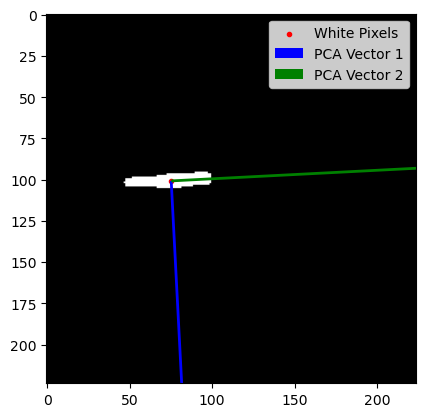

In [3]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage import io, color

# Load the binary image (replace 'your_binary_image.png' with your actual image file)
image_path = mask_list[300]+'2.png'
binary_image = io.imread(image_path, as_gray=True)

# Extract the coordinates of the white pixels
white_pixel_coords = np.argwhere(binary_image == 255)

# Create a PCA object
pca = PCA(n_components=2)

# Fit the PCA model to the white pixel coordinates
pca.fit(white_pixel_coords)

# Transform the white pixel coordinates using PCA
pca_vector = pca.transform(white_pixel_coords)
base_u=pca.components_[1, 0]
base_v=pca.components_[1, 1]
base_orthogonal_u=pca.components_[0, 0]
base_orthogonal_v=pca.components_[0, 1]
# Plot the binary image
plt.imshow(binary_image, cmap='gray')

# Plot the PCA vector on the binary image
plt.scatter(pca.mean_[1], pca.mean_[0], c='red', marker='.', label='White Pixels')
plt.quiver(pca.mean_[1], pca.mean_[0], base_orthogonal_u, base_orthogonal_v, scale=0.1, color='blue', label='PCA Vector 1')
plt.quiver(pca.mean_[1], pca.mean_[0], base_u, base_v, scale=0.1, color='green', label='PCA Vector 2')


plt.legend()
plt.show()


In [4]:

slope =-base_u/base_v
a = -1
b = slope

vector_equation = f"{a}x + {b}y = 0"
print(vector_equation)


-1x + -19.36733331588862y = 0


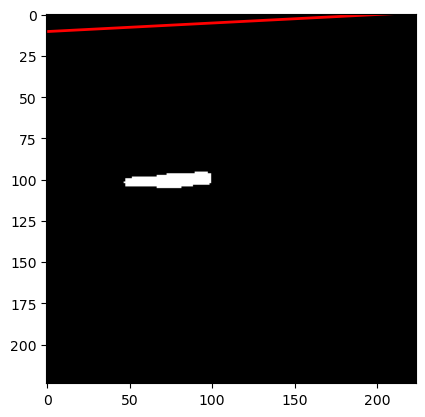

In [5]:
# Define the coefficients of the vector equation

c = -200

# Calculate the x and y values for the vector
x = np.linspace(0, binary_image.shape[1], 2)
y = (c - a*(x)) / b

# Plot the binary image
plt.imshow(binary_image, cmap='gray')

# Plot the vector on the binary image
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=0.1, color='red')

plt.show()


In [6]:
x[1:]-x[:-1]

array([224.])